# Requirements and Planning

- Write a sql query to acquire data

    - last transaction during May and June 2017
    - single-unit residential properties only
    

- Figure out state and county for each property


- Figure out distribution of tax rates by county
    - Calculate tax rate using givens of home value and taxes
    
    
- MVP - Use square feet of home, # of bedrooms, and # of bathrooms to predict home value

    - Deliverable 1: Presentation slides (Audience == Zillow Team)
    - Deliverable 2: Repo containing Jupyter Notebook displaying your work through the pipeline with detailed documentation.
    - Deliverable 3: .py modules containing functions that ensure your work is neat, readable, and recreatable.
    - Deliverable 4: README.md file with data dictionary

# Imports

In [74]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score

from math import sqrt
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


import env
import util
from wrangle_zillow import wrangle_zillow
import explore
import split_scale
import features_zillow
import model_zillow
import evaluate

# Acquire and Prep df

- My function, wrangle_zillow, uses the SQL query I created to acquire data from the Zillow database, drop rows containing Null values, and set my columns to the appropriate data types and and desired names.


- My SQL query filtered the Zillow data to include only single unit residential properties whose last transactions were in the months of May and June of 2017. I also filtered out any rows that had a value of zero for bedroomcnt or bathroomcnt which gave me a row count of 15,947.


- I adjusted my SQL query to filter out any rows that had a value below one or above six for bedrooms or a value below one or above five for bathrooms which gave me a total of 15,722 rows to work with in my models. I based my decision for the upper bounds on bedrooms and bathrooms on the equation Q3 + 1.5 * IQR. 


- However, when I ran my models, the $R^2$ scores went down by more than ten percent, so my second iteration left in the outliers and used my original SQL query from above.

In [39]:
# I commented this out once I made my csv with my cleaned and prepped df
# df = wrangle_zillow()

df = pd.read_csv('zillow.csv', index_col=0)

In [40]:
print(f'My original dataframe is coming in with {df.shape[0]} rows and {df.shape[1]} columns.')

My original dataframe is coming in with 15947 rows and 10 columns.


In [41]:
df.head()

,bedrooms,bathrooms,square_feet,taxes,home_value,propertylandusedesc,fips_number,zip_code,tax_rate,county_name
0,4.0,2.0,1604,6089.82,498347.0,Single Family Residential,6037,96415.0,0.012220,Los Angeles
1,3.0,3.0,2384,6679.55,549917.0,Single Family Residential,6037,96452.0,0.012146,Los Angeles
2,3.0,2.0,1574,3876.31,235272.0,Single Family Residential,6037,97319.0,0.016476,Los Angeles
3,2.0,2.0,1619,4206.15,340000.0,Single Family Residential,6037,97329.0,0.012371,Los Angeles
4,2.0,3.0,2408,24353.42,2017254.0,Single Family Residential,6037,96086.0,0.012073,Los Angeles


## Summarize the df using tell_me_about(df) function

- My function, tell_me_about(df), allows me to view important descriptive information about my data before I begin to work with it. 

In [42]:
util.tell_me_about(df)

DataFrame Shape:

(15947, 10)

Info about:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15947 entries, 0 to 15955
Data columns (total 10 columns):
bedrooms               15947 non-null float64
bathrooms              15947 non-null float64
square_feet            15947 non-null int64
taxes                  15947 non-null float64
home_value             15947 non-null float64
propertylandusedesc    15947 non-null object
fips_number            15947 non-null int64
zip_code               15947 non-null float64
tax_rate               15947 non-null float64
county_name            15947 non-null object
dtypes: float64(6), int64(2), object(2)
memory usage: 1.3+ MB
None

Describe:

           bedrooms     bathrooms   square_feet          taxes    home_value  \
count  15947.000000  15947.000000  15947.000000   15947.000000  1.594700e+04   
mean       3.253026      2.215213   1836.276729    5680.471976  4.632920e+05   
std        0.949431      1.025248    980.727638    7466.513817  6.434062e+

## Create a Field that Calculates the Tax Rate

- I will use home value and taxes to create a calculated column to deliver information about the tax rate distribution for each county in my df.

In [43]:
df["tax_rate"] = df["taxes"] / df["home_value"]
df.head()

,bedrooms,bathrooms,square_feet,taxes,home_value,propertylandusedesc,fips_number,zip_code,tax_rate,county_name
0,4.0,2.0,1604,6089.82,498347.0,Single Family Residential,6037,96415.0,0.012220,Los Angeles
1,3.0,3.0,2384,6679.55,549917.0,Single Family Residential,6037,96452.0,0.012146,Los Angeles
2,3.0,2.0,1574,3876.31,235272.0,Single Family Residential,6037,97319.0,0.016476,Los Angeles
3,2.0,2.0,1619,4206.15,340000.0,Single Family Residential,6037,97329.0,0.012371,Los Angeles
4,2.0,3.0,2408,24353.42,2017254.0,Single Family Residential,6037,96086.0,0.012073,Los Angeles


## Add the county name to the df based on the fips number.

In [44]:
df["county_name"] = df["fips_number"].map({6037: "Los Angeles", 6059: "Orange", 6111: "Ventura"})
df.head()

,bedrooms,bathrooms,square_feet,taxes,home_value,propertylandusedesc,fips_number,zip_code,tax_rate,county_name
0,4.0,2.0,1604,6089.82,498347.0,Single Family Residential,6037,96415.0,0.012220,Los Angeles
1,3.0,3.0,2384,6679.55,549917.0,Single Family Residential,6037,96452.0,0.012146,Los Angeles
2,3.0,2.0,1574,3876.31,235272.0,Single Family Residential,6037,97319.0,0.016476,Los Angeles
3,2.0,2.0,1619,4206.15,340000.0,Single Family Residential,6037,97329.0,0.012371,Los Angeles
4,2.0,3.0,2408,24353.42,2017254.0,Single Family Residential,6037,96086.0,0.012073,Los Angeles


## Beautiful! Now I will save my df to csv for future use.

In [45]:
# Commented out because I only needed to make this once. Now I just import my csv for df.
# df.to_csv('zillow.csv')

In [48]:
df = pd.read_csv('zillow.csv', index_col=0)

In [49]:
print(f'My dataframe is coming in from my csv with {df.shape[0]} rows and {df.shape[1]} columns.')

My dataframe is coming in from my csv with 15947 rows and 10 columns.


# Create Distributions of the Tax Rates by County:

- I found the breakdown of fips_numbers at the USDA government site:

https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697
    

- Using the fips_numbers, I found that all three counties represented in my data are in the state of California; they are Los Angeles County, Orange County, and Ventura County.


- I looked at the mean and median tax_rate for each county and found that Los Angeles County has the highest overall tax rate either way. All of the tax rates are similar, though. 


- I looked at the count of properties in each county, and my df is made up of 78% Los Angeles County properties, 17% Orange County, and 5% Ventura County. 


- I also created a function, tax_distribution_viz(df), to take a quick look at the tax rate distributions by county.

In [50]:
county_mean_tax_rate = pd.DataFrame(df.groupby("county_name").tax_rate.mean())
county_mean_tax_rate

,tax_rate
county_name,
Los Angeles,0.013735
Orange,0.012111
Ventura,0.011499


In [51]:
county_median_tax_rate = pd.DataFrame(df.groupby("county_name").tax_rate.median())
county_median_tax_rate

,tax_rate
county_name,
Los Angeles,0.012638
Orange,0.011702
Ventura,0.011215


In [52]:
county_count = pd.DataFrame(df.groupby("county_name").county_name.count())
county_count.columns = ['count']
county_count['frequency'] = df['county_name'].value_counts(normalize=True)
county_count['percentage'] = round(county_count['frequency'] * 100)

In [53]:
county_count

,count,frequency,percentage
county_name,,,
Los Angeles,12382,0.776447,78.0
Orange,2778,0.174202,17.0
Ventura,787,0.049351,5.0


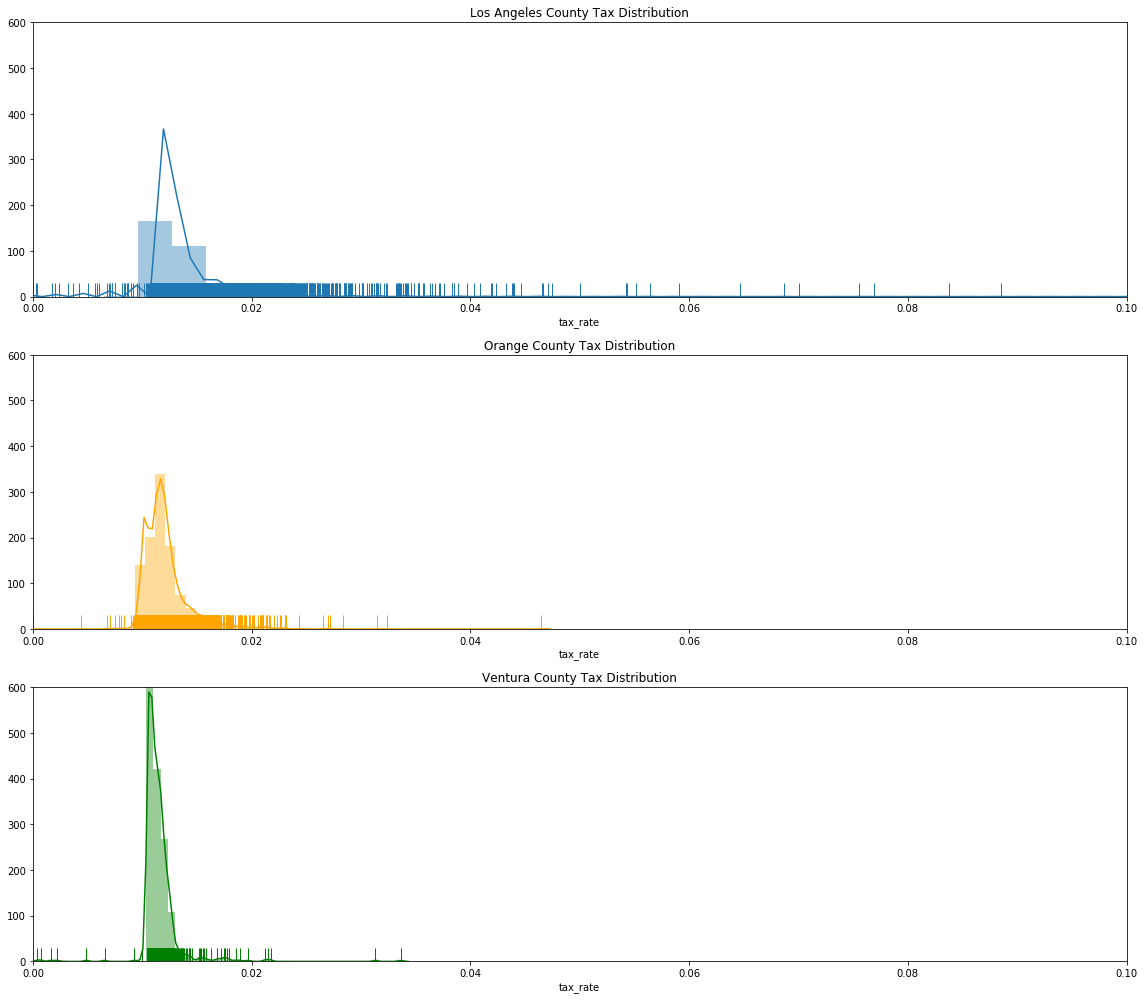

In [54]:
explore.tax_distribution_viz(df)

# Quick and Dirty Linear Regression for Baseline Model

- I have been tasked with making a first model that uses only square feet, # of bedrooms, and # of bathrooms to predict home value. I'm going to do as little exploration and prepping as possible to get this done.


- After I have my baseline model evaluation metrics, I can go back and explore my data more, do any feature engineering and selection I want, and try to beat the performance of my baseline model.

## Split and Scale my df

In [55]:
train, test = split_scale.split_my_data(df)

In [56]:
print(f'My train df is {train.shape} and my test df is {test.shape}.')

My train df is (11162, 10) and my test df is (4785, 10).


In [57]:
train.head(1)

,bedrooms,bathrooms,square_feet,taxes,home_value,propertylandusedesc,fips_number,zip_code,tax_rate,county_name
8731,3.0,2.0,1076,4464.23,383845.0,Single Family Residential,6037,96162.0,0.01163,Los Angeles


In [58]:
test.head(1)

,bedrooms,bathrooms,square_feet,taxes,home_value,propertylandusedesc,fips_number,zip_code,tax_rate,county_name
5402,4.0,3.0,2125,1403.97,91072.0,Single Family Residential,6037,96489.0,0.015416,Los Angeles


In [59]:
X_train = train[['square_feet', 'bedrooms', 'bathrooms']]
X_test = test[['square_feet', 'bedrooms', 'bathrooms']]
y_train = train[['home_value']]
y_test = test[['home_value']]

In [60]:
print(X_train.head(1), X_train.shape)

      square_feet  bedrooms  bathrooms
8731         1076       3.0        2.0 (11162, 3)


In [61]:
print(X_test.head(1), X_test.shape)

      square_feet  bedrooms  bathrooms
5402         2125       4.0        3.0 (4785, 3)


In [62]:
print(y_train.head(1), y_train.shape)

      home_value
8731    383845.0 (11162, 1)


In [64]:
print(y_test.head(1), y_test.shape)

      home_value
5402     91072.0 (4785, 1)


## IQR Robust Scaler handles outliers well, so I'll use that on X_train and X_test

In [66]:
scaler, X_train_scaled, X_test_scaled = split_scale.iqr_robust_scaler(X_train, X_test)

In [67]:
scaler

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)

In [70]:
X_train_scaled.head(3), X_test_scaled.head(3)

(       square_feet  bedrooms  bathrooms
 8731     -0.559978       0.0        0.0
 10790    -0.783969      -1.0       -1.0
 1280     -0.748833      -1.0       -1.0,
        square_feet  bedrooms  bathrooms
 5402      0.591820       1.0        1.0
 15625    -0.696130      -1.0        0.0
 5300     -0.178973       0.0        0.0)

# Baseline Model and Evaluation

In [72]:
#predictions, predictions_test = model_zillow.modeling_function(X_train_scaled, y_train, X_test_scaled, y_test)

In [73]:
#predictions

,actual,lm1,lm_baseline
0,383845.0,156834.791401,456487.606074
1,29565.0,136857.578461,456487.606074
2,162887.0,150449.959303,456487.606074
3,264896.0,664584.134198,456487.606074
4,262383.0,439235.423982,456487.606074
...,...,...,...
11157,180427.0,163763.045399,456487.606074
11158,120764.0,250707.171590,456487.606074
11159,84217.0,369627.100378,456487.606074
11160,465469.0,211629.076669,456487.606074


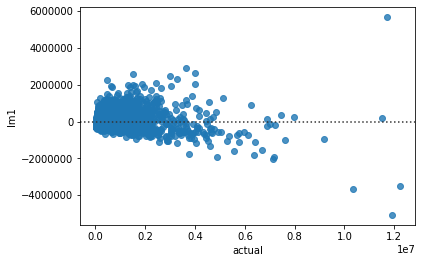

In [77]:
#evaluate.plot_residuals(predictions.actual, predictions.lm1)